In [14]:
import h5py
import numpy as np
import pandas as pd 
import os
import numpy as np
import re
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [15]:
def convert_csv_to_txt(input_file,output_file):
   
    with open(input_file, 'r') as csv_file, open(output_file, 'w') as space_delimited_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            space_delimited_file.write(' '.join(row) + '\n')

    print(f'CSV file "{input_file}" converted to space-delimited file "{output_file}"')


In [16]:
def read_file(file):
    hf = h5py.File(file, 'r')
    attributes = []
    for key in hf.keys():
        attributes.append(key)
    
    return attributes, hf


In [17]:
def get_data(hf,attributes):
    data = []
    pm = []
    acc_pm = []
    loss_pm = []
    loss_gm = []
    for i in range(len(attributes)):
        ai = hf.get(attributes[i])
        ai = np.array(ai)
        data.append(ai)
    
    return data


In [18]:
def plot_convergence(df_loss, df_accuracy, df_gap, path, model, eta_0_value):
  
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # 3 Rows, 1 Column
    handles, labels = [], []
    # Plotting for each DataFrame
    # print(df_loss.head(5))
    # print(df_accuracy.head(5))
    # print(df_gap.head(5))
    for ax, df in zip(axs, [df_loss, df_accuracy, df_gap]):
        #print(f"ax: {ax}")
        # print(f"df.columns: {df.columns}")
        for col in df.columns:
            print(f"col : {col}")
            ax.plot(df.index, df[col], label=col)
            line, = ax.plot(df.index, df[col], label=col)
            handles.append(line)
            labels.append(col)

        # ax.legend()
        ax.set_xticks(range(0, 1001, 200)) # Setting x-axis ticks as specified
        ax.grid(True)
        # ax.set_yscale('log')


        # Adding inset for magnification
        # ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')
        # ax_inset.plot(df.index, df[col], label=col, color='red')  # Plot magnified data
        # ax_inset.set_xlim(270, 300)  # Set limits for magnified portion
        # ax_inset.set_ylim(0.3, 1.5)  # Set limits for magnified portion
        # ax_inset.grid(True)
    
    # Removing duplicate handles/labels
    unique_handles, unique_labels = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)


    indexes = ['Validation Loss', 'Validation Accuracy', 'Frank-Wolfe Gap']
    
    fontsize=16
    for i, ax in enumerate(axs):
        ax.set_ylabel(indexes[i], fontsize=fontsize)
        ax.set_xlabel('Global Iteration', fontsize=fontsize)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    fig.subplots_adjust(top=0.85) 
    legend_fontsize = 16  # Specify font size here
    fig.legend(unique_handles, unique_labels, loc='upper center', ncol=4, title="", fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    
    plt.draw()
    plt.savefig(path +'ablation_' + model + '_eta_' + str(eta_0_value) + '_lambda.png', bbox_inches='tight', dpi=300)

    plt.show()


In [19]:
def convergence_analysis(path, model_name, eta_0_value):
    dir_list = os.listdir(path)
    
    df_loss = pd.DataFrame()
    df_accuracy = pd.DataFrame()
    df_gap = pd.DataFrame()
    
    for file_name in dir_list:
        print(file_name)
        if file_name.endswith(".h5"):

            pattern = 'lamdba_0_(\d+\.?\d*)_eta_0_(\d+\.?\d*)'
            match = re.search(pattern, file_name)

            # Format the matched parts
            if match:
                formatted_part = f'lamdba_0 {match.group(1)}_eta_0 {match.group(2)}'
            else:
                formatted_part = 'No match found'
            # Replace underscores with spaces except for the ones right after "lambda" and "eta"
            column_name = formatted_part.replace("lamdba_0_", "lamdba_0 ").replace("eta_0_", "eta_0 ")

            print(column_name)
            
            if eta_0_value in column_name:
                # print(f"column name : {column_name}")
                attributes, hf = read_file(path+file_name)

                data = get_data(hf,attributes)
                #id=0
                for key in hf.keys():
                    attributes.append(key)
                # print("id [",id,"] :", key)
                #id+=1
                    
                val_loss = np.array(hf.get('global_test_loss'))
                #print(f"val_loss : {val_loss}")
                val_acc = np.array(hf.get('global_test_accuracy'))
                #print(f"val_acc : {val_acc}")
                gap = np.array(hf.get('fw_gap'))
                    
                df_loss[column_name] = val_loss
                df_accuracy[column_name] = val_acc
                df_gap[column_name] = gap
    
    
    plot_convergence(df_loss, df_accuracy, df_gap, path, model_name, eta_0_value)

LMO_lmo_l2_lamdba_0_0.001_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.1_lambda.png
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.01
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.001_lambda.png
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.01_lambda.png
LMO_lmo_l2_lamd

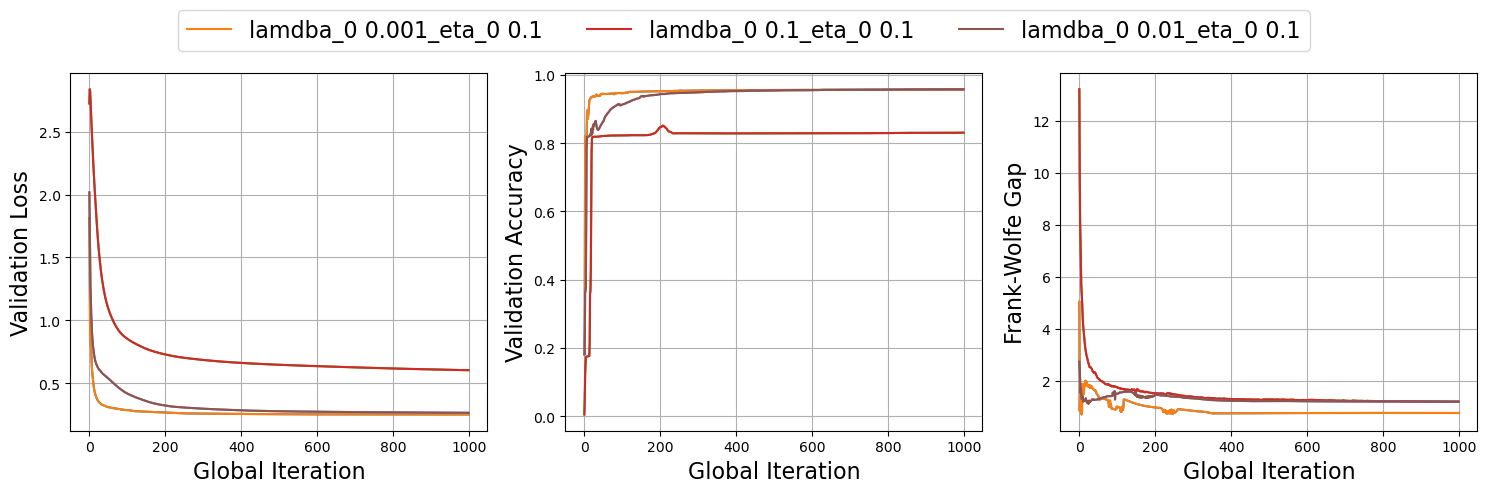

LMO_lmo_l2_lamdba_0_0.001_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.1_lambda.png
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.01
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.001_lambda.png
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.01_lambda.png
LMO_lmo_l2_lamd

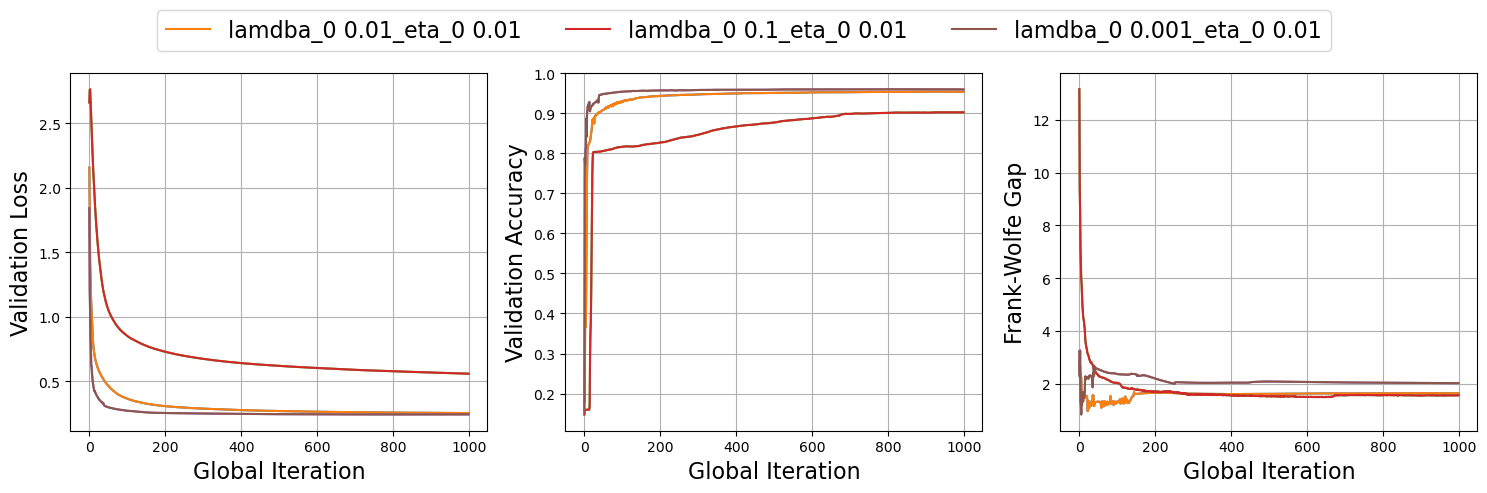

LMO_lmo_l2_lamdba_0_0.001_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.01
LMO_lmo_l2_lamdba_0_0.01_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.01_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.1_lambda.png
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.01_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.01
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.001_lambda.png
LMO_lmo_l2_lamdba_0_0.1_eta_0_0.1_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.1_eta_0 0.1
LMO_lmo_l2_lamdba_0_0.001_eta_0_0.001_kappa_10.0_labels_3_global_iters_1000_12_03_2024.h5
lamdba_0 0.001_eta_0 0.001
ablation_fedfw_synthetic_DNN_lmo_l2_3_eta_eta_0 0.01_lambda.png
LMO_lmo_l2_lamd

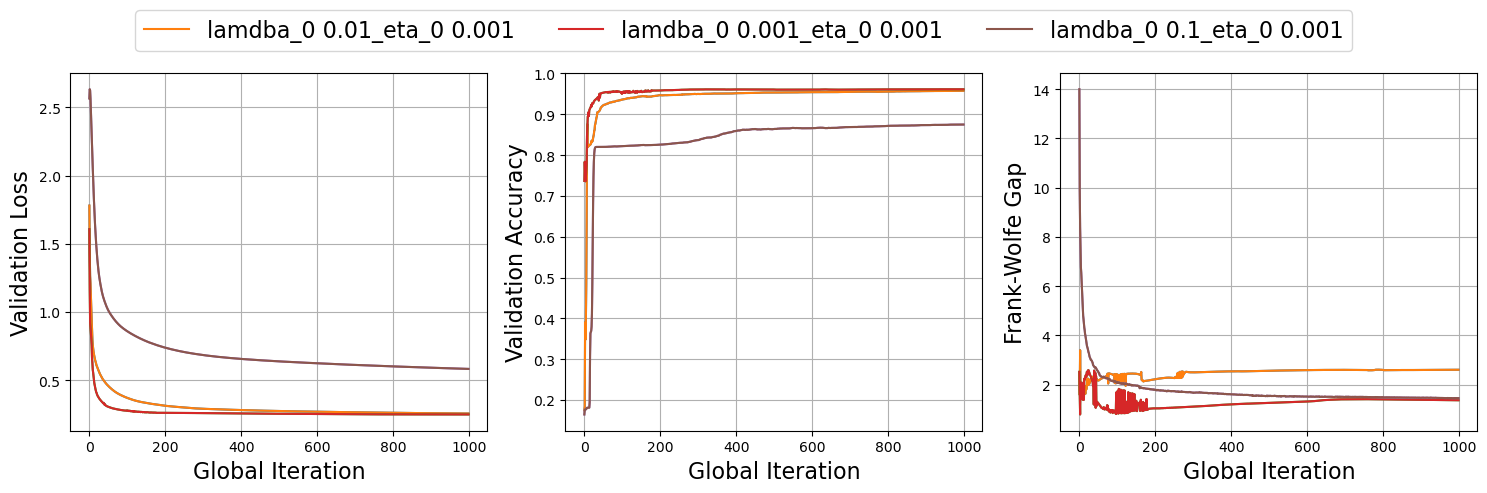

In [22]:
path = "/proj/sourasb-220503/codebase/FedFWplus/results/FedFW/SYNTHETIC/DNN/hyperparameters/lmo_l2/3/"
model_name = "fedfw_synthetic_DNN_lmo_l2_3"
eta_0_values = ['eta_0 0.1', 'eta_0 0.01', 'eta_0 0.001']
for eta_0_value in eta_0_values:
    convergence_analysis(path, model_name, eta_0_value)